In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# --- When to Use MICE and Data Requirements ---
# MICE (Multiple Imputation by Chained Equations) is an advanced technique for handling missing data.
# It's particularly useful under the "Missing at Random" (MAR) assumption, which means the probability
# of a value being missing depends only on other observed variables in the dataset, not on the
# missing value itself.
#
# Requirements:
# 1. Data should be Missing at Random (MAR) or Missing Completely at Random (MCAR). It may not perform
#    well for "Missing Not at Random" (MNAR) scenarios.
# 2. It works best with numerical and categorical data.
# 3. The variables in the dataset should have some correlation with each other, as MICE uses these
#    relationships to predict and impute the missing values.



In [2]:
# --- 1. Load a Sample Dataset ---
# We'll use the California Housing dataset from scikit-learn.
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['MedHouseVal'] = housing.target # Add the target variable to the DataFrame

print("Original DataFrame head:")
print(df.head())
print("\nOriginal DataFrame info (checking for missing values):")
df.info()





Original DataFrame head:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

Original DataFrame info (checking for missing values):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     

In [3]:
# --- 2. Introduce Missing Values for Demonstration ---
# The original dataset is complete. To demonstrate MICE, we will artificially introduce
# some missing values (NaNs) into the 'MedInc' (Median Income) and 'HouseAge' columns.
df_missing = df.copy()
np.random.seed(42) # for reproducibility

# Introduce 15% missing values in MedInc
missing_mask_medinc = np.random.rand(*df_missing['MedInc'].shape) < 0.15
df_missing.loc[missing_mask_medinc, 'MedInc'] = np.nan

# Introduce 10% missing values in HouseAge
missing_mask_houseage = np.random.rand(*df_missing['HouseAge'].shape) < 0.10
df_missing.loc[missing_mask_houseage, 'HouseAge'] = np.nan

print("\nDataFrame head with missing values introduced:")
print(df_missing.head())
print("\nNumber of missing values in each column:")
print(df_missing.isnull().sum())





DataFrame head with missing values introduced:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574       NaN  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

Number of missing values in each column:
MedInc         3104
HouseAge       2062
AveRooms          0
AveBedrms         0
Population        0
AveOccup          0
Latitude          0
Longitude         0
MedHouseVal       0
dtype: int64


In [4]:
# --- 3. Apply MICE Imputation ---
# We use scikit-learn's IterativeImputer, which is an implementation of the MICE algorithm.
# It models each feature with missing values as a function of other features and uses that
# estimate for imputation. It does this iteratively, cycling through the features.

# Initialize the imputer
# --- IterativeImputer Hyperparameters Explained ---
# estimator: The estimator object to use for predicting missing values.
#            Default is `BayesianRidge()`. Other regressors can be used.
# max_iter: The maximum number of imputation rounds to perform. Each round imputes all features.
#           Default is 10.
# random_state: Seed for the random number generator for reproducibility.
# min_value: The minimum possible imputed value. Useful for features that cannot be negative,
#            like income or age. Default is -inf.
# max_value: The maximum possible imputed value. Default is +inf.
# initial_strategy: How to initialize the missing values before the first iteration.
#                   Options: 'mean', 'median', 'most_frequent', 'constant'. Default is 'mean'.
# imputation_order: The order in which features are imputed.
#                   Options: 'ascending', 'descending', 'roman', 'arabic', 'random'.
#                   Default is 'ascending' (from feature 0 to n-1).
# tol: The tolerance for the stopping condition. The imputation stops if the change between
#      iterations is less than `tol * max(abs(X))`. Default is 1e-3.
# n_nearest_features: The number of other features to use for imputation. Can speed up computation
#                     on wide datasets. Default is None (uses all features).
# sample_posterior: If True, it samples from the posterior predictive distribution of the
#                   estimator, adding stochasticity. If False, it uses the deterministic prediction.
#                   Default is False.
mice_imputer = IterativeImputer(max_iter=10, random_state=42, min_value=0)

# Apply the imputer to the DataFrame.
# The imputer returns a NumPy array, so we'll convert it back to a DataFrame.
df_imputed_data = mice_imputer.fit_transform(df_missing)
df_imputed = pd.DataFrame(df_imputed_data, columns=df_missing.columns)




In [5]:
# --- 4. Show the Results ---
# Check if there are any missing values left in the imputed DataFrame.
print("\nNumber of missing values after MICE imputation:")
print(df_imputed.isnull().sum())

# Display the head of the imputed DataFrame to see the filled-in values.
print("\nHead of the DataFrame after MICE imputation:")
print(df_imputed.head())





Number of missing values after MICE imputation:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Head of the DataFrame after MICE imputation:
   MedInc   HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252  41.000000  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014  21.000000  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574  29.484238  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431  52.000000  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462  52.000000  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


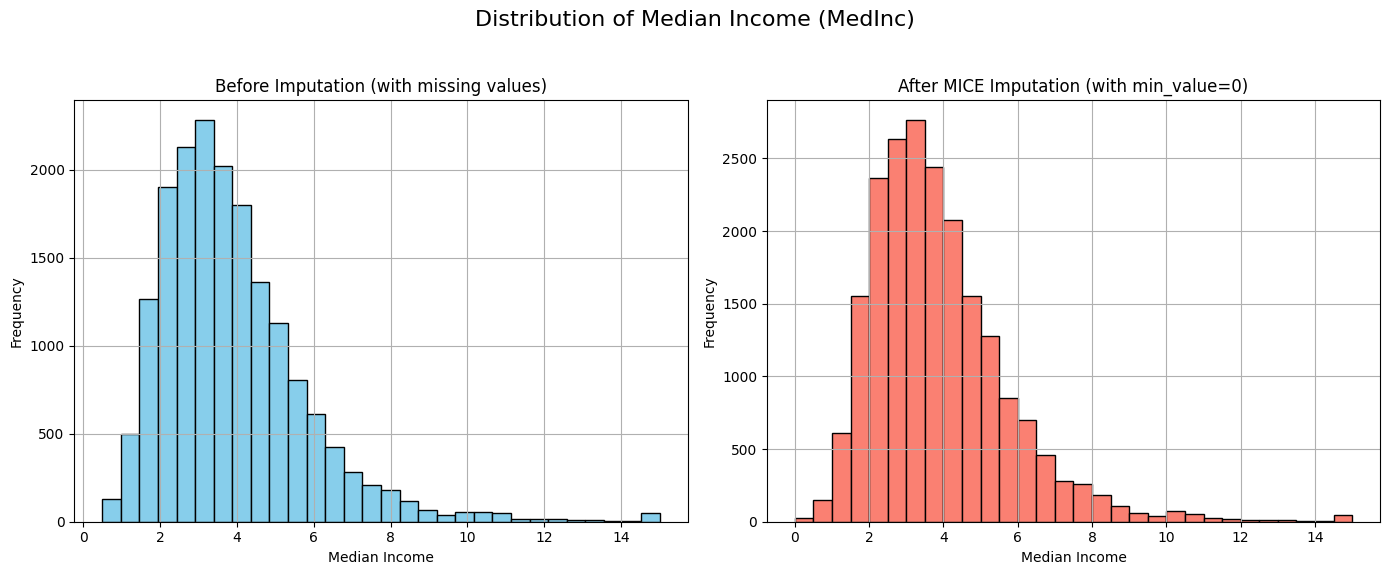


Summary statistics for 'MedInc' (Original vs. Imputed):
Original Data (no missing values):
count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: MedInc, dtype: float64

Imputed Data:
count    20640.000000
mean         3.868299
std          1.860674
min          0.000000
25%          2.580400
50%          3.540300
75%          4.742300
max         15.000100
Name: MedInc, dtype: float64


In [6]:
# --- 5. Visualize the Effect of Imputation ---
# A good way to check the quality of the imputation is to see if the distribution
# of the imputed variable is similar to the original distribution.

# We will compare the distribution of the 'MedInc' column before and after imputation.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribution of Median Income (MedInc)', fontsize=16)

# Plot the original distribution (ignoring NaNs for the "before" plot)
df_missing['MedInc'].hist(ax=axes[0], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Before Imputation (with missing values)')
axes[0].set_xlabel('Median Income')
axes[0].set_ylabel('Frequency')

# Plot the distribution after MICE imputation
df_imputed['MedInc'].hist(ax=axes[1], bins=30, color='salmon', edgecolor='black')
axes[1].set_title('After MICE Imputation (with min_value=0)')
axes[1].set_xlabel('Median Income')
axes[1].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# We can also compare summary statistics
print("\nSummary statistics for 'MedInc' (Original vs. Imputed):")
print("Original Data (no missing values):")
print(df['MedInc'].describe())
print("\nImputed Data:")
print(df_imputed['MedInc'].describe())




In [7]:
# --- 6. Compare Original vs. Imputed Values ---
# To directly see how well the imputer performed, we can create a DataFrame that shows
# the original value that was removed and the value that was imputed in its place.

# Create a comparison DataFrame for 'MedInc'
comparison_df = pd.DataFrame({
    'Original_MedInc': df.loc[missing_mask_medinc, 'MedInc'],
    'Imputed_MedInc': df_imputed.loc[missing_mask_medinc, 'MedInc']
})

print("\n--- Comparison of Original vs. Imputed Values for MedInc ---")
print(comparison_df.head(10))

# Create a comparison DataFrame for 'HouseAge'
comparison_df_age = pd.DataFrame({
    'Original_HouseAge': df.loc[missing_mask_houseage, 'HouseAge'],
    'Imputed_HouseAge': df_imputed.loc[missing_mask_houseage, 'HouseAge']
})

print("\n--- Comparison of Original vs. Imputed Values for HouseAge ---")
print(comparison_df_age.head(10))


--- Comparison of Original vs. Imputed Values for MedInc ---
    Original_MedInc  Imputed_MedInc
6            3.6591        4.627737
10           3.2031        4.183930
21           1.7135        2.874470
29           1.6875        2.578503
32           1.7969        2.585448
37           1.4103        1.851254
40           2.0978        2.288369
42           1.0250        1.680142
56           1.5057        2.001928
58           1.2171        1.747512

--- Comparison of Original vs. Imputed Values for HouseAge ---
     Original_HouseAge  Imputed_HouseAge
2                 52.0         29.484238
6                 52.0         33.889937
8                 42.0         35.787463
30                49.0         35.015364
39                52.0         34.326566
74                20.0         35.515523
84                35.0         35.765260
97                29.0         38.624384
121               37.0         34.839577
141               52.0         29.432688
